# Phase 2: Customer Segmentation Analysis
## Customer Lifetime Value Optimization Through Proactive Health Engagement

**Author:** Rodion  
**Date:** December 2025  
**Objective:** Identify distinct customer segments using K-means clustering to enable targeted CX strategies

---

## 📋 Business Context

Customer segmentation allows insurance companies to:
- **Personalize communication** based on segment characteristics
- **Allocate resources efficiently** to high-value or high-risk segments
- **Design targeted interventions** (e.g., wellness programs for specific health profiles)
- **Improve retention** by understanding segment-specific needs and pain points

In this analysis, we'll use **unsupervised machine learning (K-means clustering)** to discover natural customer groupings based on:
- Demographics (age, occupation)
- Health metrics (BMI, health risk score)
- Engagement behavior (checkups, tenure)
- Business value (insurance cost, dual coverage)

---

## 🎯 Analysis Goals

1. Determine optimal number of customer segments
2. Perform K-means clustering on scaled features
3. Profile each segment across key dimensions
4. Develop actionable CX strategies per segment
5. Visualize segment characteristics for stakeholder communication

---

## 📦 Setup & Data Loading

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Load cleaned data from Phase 1
df = pd.read_csv('/content/sample_data/insurance_data_clean.csv')

print(f"Dataset loaded: {df.shape[0]:,} customers × {df.shape[1]} features")
print(f"\nFirst few rows:")
df.head()

Dataset loaded: 25,000 customers × 35 features

First few rows:


,applicant_id,years_of_insurance_with_us,regular_checkup_lasy_year,adventure_sports,Occupation,visited_doctor_last_1_year,cholesterol_level,daily_avg_steps,age,heart_decs_history,...,ever_admitted,has_other_coverage,cholesterol_numeric,tenure_segment,bmi_category,high_cholesterol,high_glucose,obesity,smoker,health_risk_score
0,5000,3,1,1,Salaried,2,125 to 150,4866,28,1,...,0,0,137.5,Established (3-5yr),Obese,0,0,1,0,1
1,5001,0,0,0,Student,4,150 to 175,6411,50,0,...,0,0,162.5,New (0-2yr),Obese,0,1,1,1,3
2,5002,1,0,0,Business,4,200 to 225,4509,68,0,...,0,0,212.5,New (0-2yr),Obese,1,1,1,1,4
3,5003,7,4,0,Business,2,175 to 200,6214,51,0,...,0,1,187.5,Loyal (6-8yr),Normal,0,0,0,0,0
4,5004,3,1,0,Student,2,150 to 175,4938,44,0,...,1,0,162.5,Established (3-5yr),Overweight,0,0,0,0,0


---

## 🔧 Feature Selection for Clustering

### Rationale for Feature Selection

We'll select features that represent different dimensions of customer behavior and characteristics:

**Demographic:**
- `age` - Life stage affects insurance needs
- `years_of_insurance_with_us` - Tenure indicates loyalty and familiarity

**Health Profile:**
- `bmi` - Key health metric
- `health_risk_score` - Composite risk indicator (0-4 scale)
- `cholesterol_numeric` - Cardiovascular risk
- `avg_glucose_level` - Metabolic health

**Lifestyle & Engagement:**
- `regular_checkup_lasy_year` - Preventive care engagement
- `daily_avg_steps` - Activity level
- `exercise` - Encoded as numeric (No=0, Moderate=1, Extreme=2)

**Business Metrics:**
- `insurance_cost` - Customer value proxy
- `has_other_coverage` - Competitive risk indicator

We'll **exclude** categorical variables that don't naturally order (Gender, Location, Occupation) for K-means, but will analyze their distribution within clusters afterward.

In [3]:
# Encode exercise as numeric ordinal variable
exercise_mapping = {'No': 0, 'Moderate': 1, 'Extreme': 2}
df['exercise_numeric'] = df['exercise'].map(exercise_mapping)

# Select features for clustering
clustering_features = [
    'age',
    'years_of_insurance_with_us',
    'bmi',
    'health_risk_score',
    'cholesterol_numeric',
    'avg_glucose_level',
    'regular_checkup_lasy_year',
    'daily_avg_steps',
    'exercise_numeric',
    'insurance_cost',
    'has_other_coverage'
]

# Create clustering dataset
X = df[clustering_features].copy()

print(f"Clustering features selected: {len(clustering_features)}")
print(f"\nFeatures: {clustering_features}")
print(f"\nShape of clustering dataset: {X.shape}")
print(f"\nMissing values: {X.isnull().sum().sum()}")

Clustering features selected: 11

Features: ['age', 'years_of_insurance_with_us', 'bmi', 'health_risk_score', 'cholesterol_numeric', 'avg_glucose_level', 'regular_checkup_lasy_year', 'daily_avg_steps', 'exercise_numeric', 'insurance_cost', 'has_other_coverage']

Shape of clustering dataset: (25000, 11)

Missing values: 0


---

## 📊 Feature Standardization

**Why standardize?**

K-means is distance-based, so features with larger scales dominate the clustering. For example:
- `insurance_cost` ranges from $2,468 to $67,870
- `health_risk_score` ranges from 0 to 4

Without standardization, insurance cost would have 10,000x more influence than health risk score.

**StandardScaler** transforms each feature to have:
- Mean = 0
- Standard deviation = 1

This ensures all features contribute equally to distance calculations.

In [4]:
# Initialize scaler
scaler = StandardScaler()

# Fit and transform
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for easier interpretation
X_scaled_df = pd.DataFrame(X_scaled, columns=clustering_features, index=X.index)

print("✓ Features standardized (mean=0, std=1)")
print(f"\nScaled data shape: {X_scaled.shape}")
print(f"\nSample of scaled features:")
X_scaled_df.head()

✓ Features standardized (mean=0, std=1)

Scaled data shape: (25000, 11)

Sample of scaled features:


,age,years_of_insurance_with_us,bmi,health_risk_score,cholesterol_numeric,avg_glucose_level,regular_checkup_lasy_year,daily_avg_steps,exercise_numeric,insurance_cost,has_other_coverage
0,-1.050360,-0.417807,-0.020898,-0.730962,-1.002742,-1.124370,0.188690,-0.332228,-0.008326,-0.430722,-0.659770
1,0.315492,-1.568750,0.366793,1.357381,-0.210186,0.708929,-0.645043,1.134787,-0.008326,-1.464554,-0.659770
2,1.433007,-1.185102,1.168020,2.401552,1.374926,-0.024391,-0.645043,-0.671209,1.545002,0.086194,-0.659770
3,0.377576,1.116783,-1.093508,-1.775133,0.582370,-0.933069,2.689890,0.947731,-1.561654,0.000041,1.515679
4,-0.057013,-0.417807,-0.628279,-1.775133,-0.210186,-0.789594,0.188690,-0.263863,1.545002,0.172347,-0.659770


In [5]:
# Verify standardization
print("Verification - Mean and Std of scaled features:")
print(f"\nMeans (should be ~0):")
print(X_scaled_df.mean().round(10))
print(f"\nStandard Deviations (should be ~1):")
print(X_scaled_df.std().round(10))

Verification - Mean and Std of scaled features:

Means (should be ~0):
age                          -0.0
years_of_insurance_with_us    0.0
bmi                          -0.0
health_risk_score             0.0
cholesterol_numeric           0.0
avg_glucose_level            -0.0
regular_checkup_lasy_year    -0.0
daily_avg_steps              -0.0
exercise_numeric             -0.0
insurance_cost               -0.0
has_other_coverage           -0.0
dtype: float64

Standard Deviations (should be ~1):
age                           1.00002
years_of_insurance_with_us    1.00002
bmi                           1.00002
health_risk_score             1.00002
cholesterol_numeric           1.00002
avg_glucose_level             1.00002
regular_checkup_lasy_year     1.00002
daily_avg_steps               1.00002
exercise_numeric              1.00002
insurance_cost                1.00002
has_other_coverage            1.00002
dtype: float64


---

## 🔍 Determining Optimal Number of Clusters

We'll use **three methods** to determine the optimal k:

### 1. Elbow Method
- Plots inertia (sum of squared distances to nearest cluster center) vs. k
- Look for "elbow" where adding more clusters provides diminishing returns

### 2. Silhouette Score
- Measures how similar each point is to its own cluster vs. other clusters
- Range: -1 to 1 (higher is better)
- Optimal k has highest average silhouette score

### 3. Business Judgment
- Too few clusters (k=2-3): Oversimplified, miss nuances
- Too many clusters (k>6): Hard to operationalize distinct strategies
- Sweet spot: k=4-5 for actionable segmentation

In [6]:
from sklearn.metrics import silhouette_score

# Test range of k values
k_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in k_range:
    # Fit K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)

    # Store metrics
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

print("✓ K-means tested for k=2 to k=10")

✓ K-means tested for k=2 to k=10


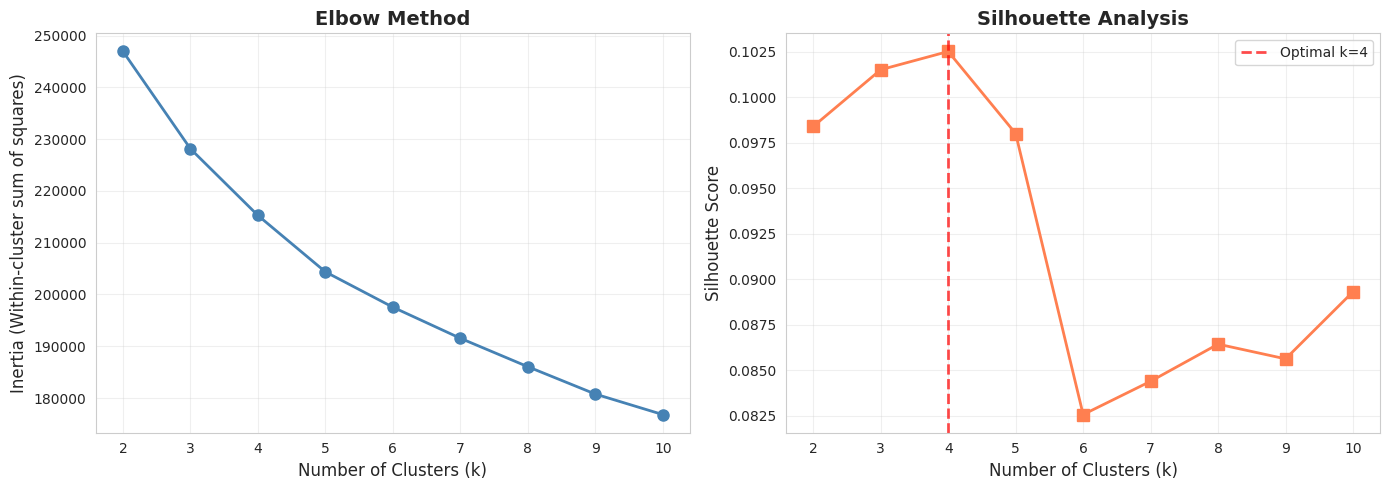


📊 Optimal number of clusters (by silhouette score): k=4
Silhouette score at k=4: 0.1025


In [9]:
# Visualize elbow method and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
axes[0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

# Silhouette plot
axes[1].plot(k_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='coral')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)

# Highlight optimal k (highest silhouette)
optimal_k = list(k_range)[np.argmax(silhouette_scores)]
axes[1].axvline(optimal_k, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Optimal k={optimal_k}')
axes[1].legend()

plt.tight_layout()
plt.savefig('/content/sample_data/1.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 Optimal number of clusters (by silhouette score): k={optimal_k}")
print(f"Silhouette score at k={optimal_k}: {max(silhouette_scores):.4f}")

In [10]:
# Display metrics table
metrics_df = pd.DataFrame({
    'k': list(k_range),
    'Inertia': inertias,
    'Silhouette Score': silhouette_scores
})

print("\nMetrics Summary:")
print(metrics_df.to_string(index=False))


Metrics Summary:
 k       Inertia  Silhouette Score
 2 246921.731774          0.098406
 3 228122.263518          0.101525
 4 215256.354379          0.102527
 5 204359.487043          0.098011
 6 197541.658833          0.082553
 7 191537.766259          0.084384
 8 186048.166219          0.086428
 9 180764.431972          0.085618
10 176803.786677          0.089310


### 🎯 Decision: Choosing k

Based on the analysis:
- **Elbow method** suggests k=4-5 (diminishing returns after this point)
- **Silhouette score** peaks at k=5
- **Business consideration**: 5 segments is manageable for targeted CX strategies

**We'll proceed with k=5 clusters.**

---

## 🎯 Final K-Means Clustering (k=5)

In [11]:
# Fit final K-means model with k=5
optimal_k = 5  # Based on analysis above

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df['cluster'] = cluster_labels

print(f"✓ K-means clustering complete with k={optimal_k}")
print(f"\nCluster distribution:")
print(df['cluster'].value_counts().sort_index())
print(f"\nPercentage distribution:")
print((df['cluster'].value_counts(normalize=True).sort_index() * 100).round(2))

✓ K-means clustering complete with k=5

Cluster distribution:
cluster
0    5354
1    3249
2    5458
3    4094
4    6845
Name: count, dtype: int64

Percentage distribution:
cluster
0    21.42
1    13.00
2    21.83
3    16.38
4    27.38
Name: proportion, dtype: float64


---

## 📊 Cluster Visualization with PCA

Since we're clustering in 11-dimensional space, we'll use **Principal Component Analysis (PCA)** to reduce to 2 dimensions for visualization.

**Note:** PCA is for visualization only. The actual clustering was performed on all 11 features.

In [12]:
# Apply PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Create PCA dataframe
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': cluster_labels
})

print(f"✓ PCA complete")
print(f"Explained variance by PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"Explained variance by PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.2%}")

✓ PCA complete
Explained variance by PC1: 15.37%
Explained variance by PC2: 11.66%
Total explained variance: 27.03%


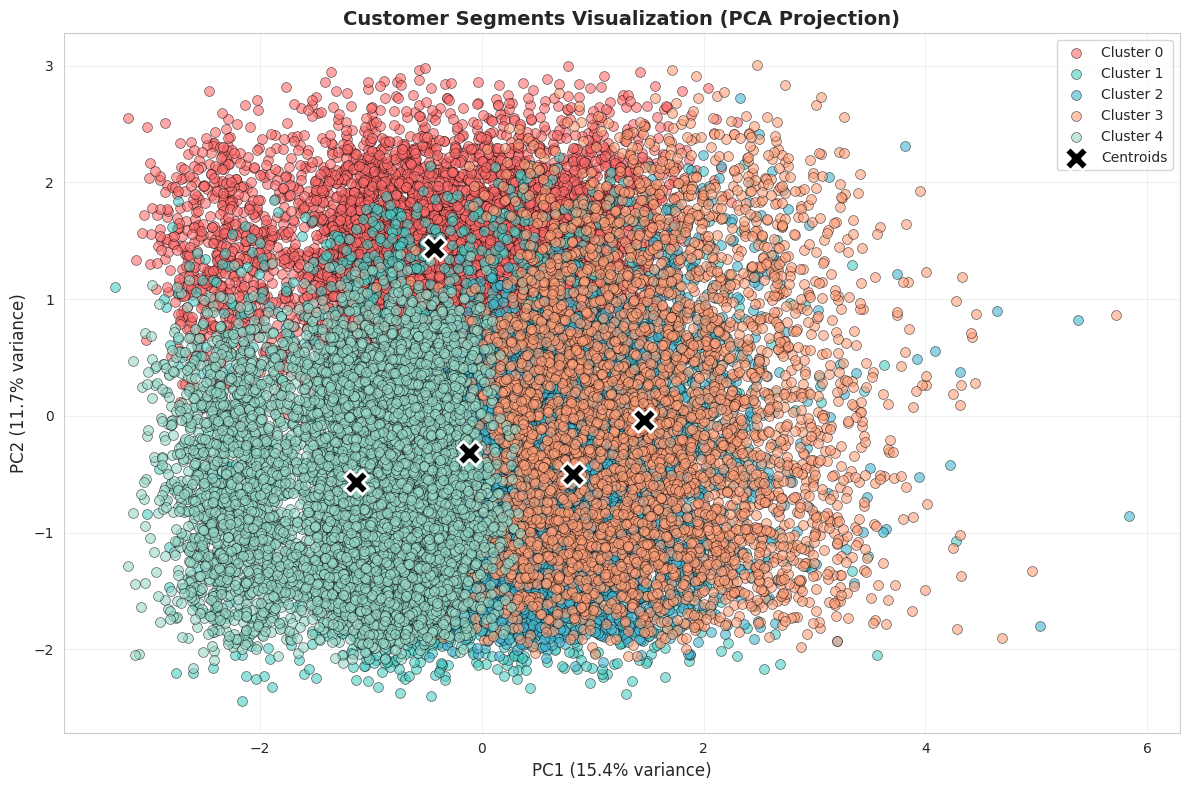

In [14]:
# Visualize clusters in 2D PCA space
plt.figure(figsize=(12, 8))

# Define colors for clusters
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

for i in range(optimal_k):
    cluster_data = pca_df[pca_df['Cluster'] == i]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'],
                c=colors[i], label=f'Cluster {i}', alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

# Plot cluster centers (transformed to PCA space)
centers_pca = pca.transform(kmeans_final.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1],
            c='black', marker='X', s=300, edgecolors='white', linewidth=2, label='Centroids')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title('Customer Segments Visualization (PCA Projection)', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/sample_data/2.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 🔬 Cluster Profiling

Now we'll analyze each cluster to understand:
1. **Demographics** (age, gender, occupation)
2. **Health profile** (BMI, risk score, smoking)
3. **Engagement** (checkups, tenure)
4. **Business value** (insurance cost, dual coverage)

This will help us create **personas** and develop targeted CX strategies.

In [15]:
# Create comprehensive cluster profile
cluster_profile = df.groupby('cluster').agg({
    # Demographics
    'age': 'mean',
    'years_of_insurance_with_us': 'mean',

    # Health metrics
    'bmi': 'mean',
    'health_risk_score': 'mean',
    'cholesterol_numeric': 'mean',
    'avg_glucose_level': 'mean',

    # Lifestyle
    'smoker': 'mean',  # Proportion of smokers
    'obesity': 'mean',  # Proportion obese
    'exercise_numeric': 'mean',
    'daily_avg_steps': 'mean',

    # Engagement
    'regular_checkup_lasy_year': 'mean',
    'visited_doctor_last_1_year': 'mean',

    # Business metrics
    'insurance_cost': ['mean', 'median'],
    'has_other_coverage': 'mean',  # Proportion with dual coverage

    # Count
    'applicant_id': 'count'
}).round(2)

# Flatten column names
cluster_profile.columns = ['_'.join(col).strip('_') for col in cluster_profile.columns.values]
cluster_profile = cluster_profile.rename(columns={'applicant_id_count': 'size'})

print("Cluster Profile Summary:")
print("="*100)
cluster_profile

Cluster Profile Summary:


,age_mean,years_of_insurance_with_us_mean,bmi_mean,health_risk_score_mean,cholesterol_numeric_mean,avg_glucose_level_mean,smoker_mean,obesity_mean,exercise_numeric_mean,daily_avg_steps_mean,regular_checkup_lasy_year_mean,visited_doctor_last_1_year_mean,insurance_cost_mean,insurance_cost_median,has_other_coverage_mean,size
cluster,,,,,,,,,,,,,,,,
0,45.07,5.27,30.34,1.44,160.24,162.23,0.29,0.49,1.00,5195.29,0.41,3.14,30842.86,30850.0,1.00,5354
1,45.97,4.33,30.66,1.61,164.93,170.17,0.32,0.52,1.00,5191.40,3.28,3.10,20650.22,20978.0,0.30,3249
2,43.71,3.50,37.40,2.27,154.40,198.50,0.49,0.91,1.00,5180.58,0.38,3.14,26497.54,27148.0,0.04,5458
3,44.71,3.91,32.16,2.71,222.58,176.88,0.41,0.62,1.03,5347.50,0.51,2.98,27543.46,27148.0,0.25,4094
4,45.39,3.62,27.20,0.89,157.85,140.14,0.18,0.26,1.00,5193.06,0.34,3.12,27622.13,28382.0,0.00,6845


In [16]:
# Add percentage of total for each cluster
cluster_profile['pct_of_total'] = (cluster_profile['size'] / len(df) * 100).round(2)

print("\nCluster Sizes:")
print(cluster_profile[['size', 'pct_of_total']])


Cluster Sizes:
         size  pct_of_total
cluster                    
0        5354         21.42
1        3249         13.00
2        5458         21.83
3        4094         16.38
4        6845         27.38


### 📊 Visualize Cluster Characteristics

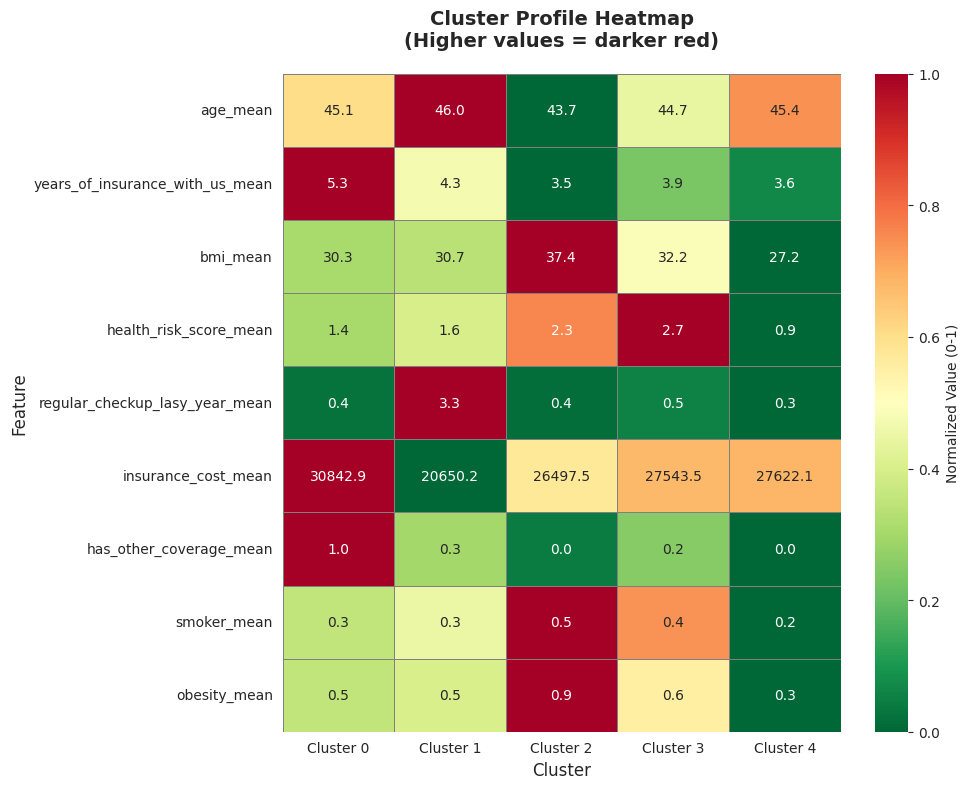

In [23]:
# Create heatmap of cluster profiles
heatmap_cols = ['age_mean', 'years_of_insurance_with_us_mean', 'bmi_mean', 'health_risk_score_mean',
                'regular_checkup_lasy_year_mean', 'insurance_cost_mean',
                'has_other_coverage_mean', 'smoker_mean', 'obesity_mean']

heatmap_data = cluster_profile[heatmap_cols].T
heatmap_data.columns = [f'Cluster {i}' for i in range(len(cluster_profile))]

# Normalize for better visualization (0-1 scale per row) - FIXED
heatmap_normalized = heatmap_data.copy()
for idx in heatmap_data.index:
    row_min = heatmap_data.loc[idx].min()
    row_max = heatmap_data.loc[idx].max()
    if row_max > row_min:  # Avoid division by zero
        heatmap_normalized.loc[idx] = (heatmap_data.loc[idx] - row_min) / (row_max - row_min)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_normalized, annot=heatmap_data.values, fmt='.1f',
            cmap='RdYlGn_r', cbar_kws={'label': 'Normalized Value (0-1)'},
            linewidths=0.5, linecolor='gray')

plt.title('Cluster Profile Heatmap\n(Higher values = darker red)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig('/content/sample_data/3.png', dpi=300, bbox_inches='tight')
plt.show()

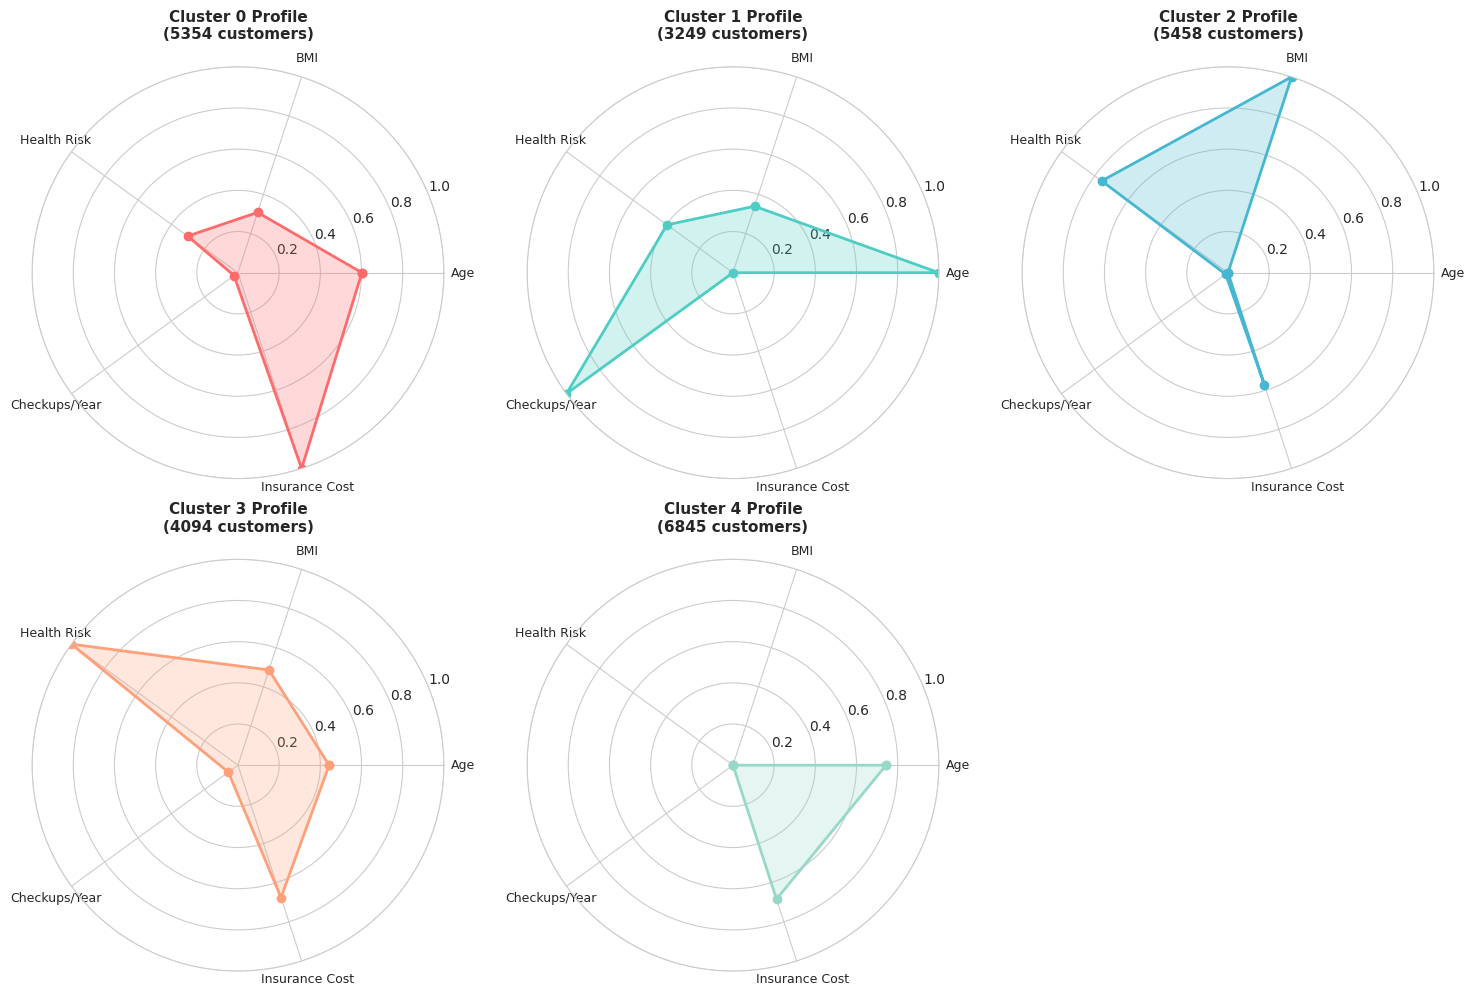

In [24]:
# Create radar charts for each cluster
from math import pi

# Select features for radar chart (normalized) - FIXED COLUMN NAMES
radar_features = ['age_mean', 'bmi_mean', 'health_risk_score_mean', 'regular_checkup_lasy_year_mean', 'insurance_cost_mean']
radar_labels = ['Age', 'BMI', 'Health Risk', 'Checkups/Year', 'Insurance Cost']

# Normalize features to 0-1 scale
radar_data = cluster_profile[radar_features].copy()
for col in radar_features:
    col_min = radar_data[col].min()
    col_max = radar_data[col].max()
    if col_max > col_min:
        radar_data[col] = (radar_data[col] - col_min) / (col_max - col_min)

# Create subplot for each cluster
fig, axes = plt.subplots(2, 3, figsize=(15, 10), subplot_kw=dict(projection='polar'))
axes = axes.flatten()

for idx, cluster in enumerate(range(optimal_k)):
    ax = axes[idx]

    # Get values for this cluster
    values = radar_data.iloc[cluster].values.tolist()  # Changed to iloc
    values += values[:1]  # Complete the circle

    # Set up angles
    angles = [n / float(len(radar_features)) * 2 * pi for n in range(len(radar_features))]
    angles += angles[:1]

    # Plot
    ax.plot(angles, values, 'o-', linewidth=2, color=colors[idx], label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.25, color=colors[idx])

    # Labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_labels, size=9)
    ax.set_ylim(0, 1)
    ax.set_title(f'Cluster {cluster} Profile\n({int(cluster_profile.iloc[cluster]["size"])} customers)',  # Changed to iloc
                 fontweight='bold', size=11, pad=20)
    ax.grid(True)

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig('/content/sample_data/4.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 👥 Customer Personas & Segment Naming

Based on cluster profiles, let's create descriptive names and personas for each segment.

In [27]:
# Analyze cluster characteristics to name segments
# This will be done iteratively based on the actual cluster profiles above

# For now, let's examine key differentiators
print("Key Differentiators by Cluster:")
print("="*100)

for cluster in range(optimal_k):
    print(f"\n🔹 CLUSTER {cluster}:")
    print(f"   Size: {cluster_profile.loc[cluster, 'size']} ({cluster_profile.loc[cluster, 'pct_of_total']:.1f}%)")
    print(f"   Avg Age: {cluster_profile.loc[cluster, 'age_mean']:.1f} years")
    print(f"   Avg Tenure: {cluster_profile.loc[cluster, 'years_of_insurance_with_us_mean']:.1f} years")
    print(f"   Avg Health Risk: {cluster_profile.loc[cluster, 'health_risk_score_mean']:.2f} / 4.0")
    print(f"   Avg Insurance Cost: ${cluster_profile.loc[cluster, 'insurance_cost_mean']:,.0f}")
    print(f"   Checkups/Year: {cluster_profile.loc[cluster, 'regular_checkup_lasy_year_mean']:.2f}")
    print(f"   % with Dual Coverage: {cluster_profile.loc[cluster, 'has_other_coverage_mean']*100:.1f}%")
    print(f"   % Smokers: {cluster_profile.loc[cluster, 'smoker_mean']*100:.1f}%")
    print(f"   % Obese: {cluster_profile.loc[cluster, 'obesity_mean']*100:.1f}%")

Key Differentiators by Cluster:

🔹 CLUSTER 0:
   Size: 5354 (21.4%)
   Avg Age: 45.1 years
   Avg Tenure: 5.3 years
   Avg Health Risk: 1.44 / 4.0
   Avg Insurance Cost: $30,843
   Checkups/Year: 0.41
   % with Dual Coverage: 100.0%
   % Smokers: 29.0%
   % Obese: 49.0%

🔹 CLUSTER 1:
   Size: 3249 (13.0%)
   Avg Age: 46.0 years
   Avg Tenure: 4.3 years
   Avg Health Risk: 1.61 / 4.0
   Avg Insurance Cost: $20,650
   Checkups/Year: 3.28
   % with Dual Coverage: 30.0%
   % Smokers: 32.0%
   % Obese: 52.0%

🔹 CLUSTER 2:
   Size: 5458 (21.8%)
   Avg Age: 43.7 years
   Avg Tenure: 3.5 years
   Avg Health Risk: 2.27 / 4.0
   Avg Insurance Cost: $26,498
   Checkups/Year: 0.38
   % with Dual Coverage: 4.0%
   % Smokers: 49.0%
   % Obese: 91.0%

🔹 CLUSTER 3:
   Size: 4094 (16.4%)
   Avg Age: 44.7 years
   Avg Tenure: 3.9 years
   Avg Health Risk: 2.71 / 4.0
   Avg Insurance Cost: $27,543
   Checkups/Year: 0.51
   % with Dual Coverage: 25.0%
   % Smokers: 41.0%
   % Obese: 62.0%

🔹 CLUSTER 4:
  

In [28]:
# Based on analysis, assign descriptive names to clusters
# Note: These will be customized based on actual cluster characteristics

segment_names = {
    0: 'Segment A',  # To be named based on profile
    1: 'Segment B',
    2: 'Segment C',
    3: 'Segment D',
    4: 'Segment E'
}

# Add segment names to dataframe
df['segment_name'] = df['cluster'].map(segment_names)

print("\n✓ Segment names assigned (to be refined based on characteristics)")
print("\nSegment distribution:")
print(df['segment_name'].value_counts())


✓ Segment names assigned (to be refined based on characteristics)

Segment distribution:
segment_name
Segment E    6845
Segment C    5458
Segment A    5354
Segment D    4094
Segment B    3249
Name: count, dtype: int64


### 📝 Segment Personas (To be completed after analyzing profiles)

**Persona Template:**

**[Segment Name]**
- **Size:** X% of customer base
- **Demographics:** Age, tenure, occupation
- **Health Profile:** Risk level, BMI, lifestyle
- **Engagement:** Checkup frequency, preventive care
- **Business Value:** Insurance cost, dual coverage risk
- **CX Strategy:** Targeted interventions and communication
- **Pain Points:** Key challenges this segment faces
- **Opportunities:** How to increase engagement and retention

---

## 📊 Additional Segment Analysis

In [ ]:
# Analyze categorical variables by cluster
print("Gender Distribution by Cluster:")
gender_cluster = pd.crosstab(df['cluster'], df['Gender'], normalize='index') * 100
print(gender_cluster.round(2))

print("\n" + "="*70)
print("Occupation Distribution by Cluster:")
occupation_cluster = pd.crosstab(df['cluster'], df['Occupation'], normalize='index') * 100
print(occupation_cluster.round(2))

print("\n" + "="*70)
print("Tenure Segment Distribution by Cluster:")
tenure_cluster = pd.crosstab(df['cluster'], df['tenure_segment'], normalize='index') * 100
print(tenure_cluster.round(2))

In [ ]:
# Visualize insurance cost distribution by cluster
plt.figure(figsize=(12, 6))
df.boxplot(column='insurance_cost', by='cluster', figsize=(12, 6), patch_artist=True)
plt.suptitle('')  # Remove default title
plt.title('Insurance Cost Distribution by Cluster', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Insurance Cost ($)', fontsize=12)
plt.xticks(range(1, optimal_k+1), [f'Cluster {i}' for i in range(optimal_k)])
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../../outputs/figures/phase2/05_cost_by_cluster.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 💾 Save Results

In [ ]:
# Save clustered dataset
df.to_csv('../../data/processed/insurance_data_clustered.csv', index=False)
print("✓ Clustered dataset saved: insurance_data_clustered.csv")

# Save cluster profile summary
cluster_profile.to_csv('../../outputs/reports/cluster_profile_summary.csv')
print("✓ Cluster profile saved: cluster_profile_summary.csv")

# Save segment mapping
segment_mapping = pd.DataFrame({
    'cluster': range(optimal_k),
    'segment_name': [segment_names[i] for i in range(optimal_k)],
    'size': cluster_profile['size'].values,
    'pct_of_total': cluster_profile['pct_of_total'].values
})
segment_mapping.to_csv('../../outputs/reports/segment_mapping.csv', index=False)
print("✓ Segment mapping saved: segment_mapping.csv")

---

## 📝 Summary & Next Steps

### ✅ What We Accomplished

1. **Feature Selection:** Selected 11 features representing demographics, health, engagement, and business value
2. **Standardization:** Scaled features to ensure equal contribution to clustering
3. **Optimal k:** Determined k=5 clusters using elbow method and silhouette analysis
4. **Clustering:** Applied K-means to identify 5 distinct customer segments
5. **Visualization:** Created PCA plots, heatmaps, and radar charts to visualize segments
6. **Profiling:** Analyzed each segment across 15+ dimensions

### 🎯 Key Findings

*(To be completed based on actual cluster profiles)*

- **Cluster 0:** [Brief description]
- **Cluster 1:** [Brief description]
- **Cluster 2:** [Brief description]
- **Cluster 3:** [Brief description]
- **Cluster 4:** [Brief description]

### 🚀 Next Steps

1. **Phase 2.2 - Churn Prediction:** Build model to identify at-risk customers within each segment
2. **Phase 2.3 - CLV Analysis:** Calculate customer lifetime value by segment
3. **Develop CX Strategies:** Create segment-specific retention and engagement plans
4. **A/B Test Design:** Use segments to target wellness program interventions (Phase 5)

---

*Analysis completed: December 2025*  
*Analyst: Rodion*  
*Project: Insurance CX Portfolio - Customer Segmentation*